In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from dynamics import SatelliteDynamics
from scipy.optimize import approx_fprime
from scipy.linalg import block_diag, solve
from utils import get_form_initial_conditions

In [2]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]
T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 2
n_x = 6  # Number of states
n_p = 3  
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 100 # Window size [min]

In [3]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [4]:
def h_function_chief(x_vec):
    """
    Computes the measurement vector based on the current state vector.
    The measurement vector includes position components.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).
    """
    return x_vec[0:3]

def H_jacobian_chief():
    """
    Computes the Jacobian of the measurement function.
    """
    H = np.zeros((3, 24))
    H[0:3, 0:3] = np.eye(3)
    return H

def h_function_deputy(x_vec):
    """
    Computes the measurement vector based on the current state vector.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    y (np.array): The measurement vector of the satellite (range [km]).
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    return np.array(
        [
            [range_deputy1_chief],
            [range_deputy1_deputy2],
            [range_deputy1_deputy3],
            [range_deputy2_chief],
            [range_deputy2_deputy3],
            [range_deputy3_chief],
        ]
    )

def H_jacobian_deputy(x_vec):
    """
    Computes the Jacobian of the measurement function.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    H (np.array): The Jacobian of the measurement function.
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    H = np.zeros((6, 24))
    H[0, 0:3] = -(r_deputy1 - r_chief).reshape(-1) / range_deputy1_chief
    H[0, 6:9] = (r_deputy1 - r_chief).reshape(-1) / range_deputy1_chief
    H[1, 6:9] = (r_deputy1 - r_deputy2).reshape(-1) / range_deputy1_deputy2
    H[1, 12:15] = -(r_deputy1 - r_deputy2).reshape(-1) / range_deputy1_deputy2
    H[2, 6:9] = (r_deputy1 - r_deputy3).reshape(-1) / range_deputy1_deputy3
    H[2, 18:21] = -(r_deputy1 - r_deputy3).reshape(-1) / range_deputy1_deputy3
    H[3, 0:3] = -(r_deputy2 - r_chief).reshape(-1) / range_deputy2_chief
    H[3, 12:15] = (r_deputy2 - r_chief).reshape(-1) / range_deputy2_chief
    H[4, 12:15] = (r_deputy2 - r_deputy3).reshape(-1) / range_deputy2_deputy3
    H[4, 18:21] = -(r_deputy2 - r_deputy3).reshape(-1) / range_deputy2_deputy3
    H[5, 0:3] = -(r_deputy3 - r_chief).reshape(-1) / range_deputy3_chief
    H[5, 18:21] = (r_deputy3 - r_chief).reshape(-1) / range_deputy3_chief
    return H

def h(x_vec):
    return np.concatenate([h_function_chief(x_vec), h_function_deputy(x_vec)])

def H(x):
    return np.concatenate((H_jacobian_chief(), H_jacobian_deputy(x)))

In [5]:
# Simulation setup
X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

In [6]:
def obj_function(X, Y):
    obj_fun = 0
    # Iterate over all sliding window time steps
    for k in range(W):
        # Extract x_1(k), x_2(k), x_3(k), x_4(k) from flattened state vector x
        x_1_k = X[n_x * (4 * k):n_x * (4 * k + 1), :]  # x_1(k)
        x_2_k = X[n_x * (4 * k + 1):n_x * (4 * k + 2), :]  # x_2(k)
        x_3_k = X[n_x * (4 * k + 2):n_x * (4 * k + 3), :]  # x_3(k)
        x_4_k = X[n_x * (4 * k + 3):n_x * (4 * k + 4), :]  # x_4(k)
        
        # Absolute residual term: observed data y for each state
        y_1_k = Y[:n_y_1, :, k]
        y_rel_k = Y[n_y_1:, :, k]

        # Update the cost function with the residuals for self-measurements
        residual = y_1_k - P @ x_1_k
        obj_fun += 1 / 2 * residual.T @ np.linalg.inv(R_chief) @ residual

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]
        
        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and update the cost function with the residuals for pairwise measurements
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)
            obj_fun += (y_ij_k - d_ij_k) ** 2 / (2 * r_deputy_pos**2)

    return obj_fun

def grad_obj_function(X, Y):
    grad_obj_fun = np.zeros_like(X)

    # Iterate over all sliding window time steps
    for k in range(W):
        # Extract x_1(k), x_2(k), x_3(k), x_4(k) from flattened state vector x
        x_1_k = X[n_x * (4 * k):n_x * (4 * k + 1), :]  # x_1(k)
        x_2_k = X[n_x * (4 * k + 1):n_x * (4 * k + 2), :]  # x_2(k)
        x_3_k = X[n_x * (4 * k + 2):n_x * (4 * k + 3), :]  # x_3(k)
        x_4_k = X[n_x * (4 * k + 3):n_x * (4 * k + 4), :]  # x_4(k)
        
        # Absolute residual term: observed data y for each state
        y_1_k = Y[:n_y_1, :, k]
        y_rel_k = Y[n_y_1:, :, k]

        # Compute gradients for the absolute residual terms
        grad_obj_fun[n_x * (4 * k):n_x * (4 * k + 1), :] -= P.T @ np.linalg.inv(R_chief) @ (y_1_k - P @ x_1_k)

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the gradient of f(x) with respect to x_i(k) and x_j(k)
            grad_obj_fun[n_x * (4 * k + (i - 1)):n_x * (4 * k + i), :] -= (y_ij_k - d_ij_k) / r_deputy_pos**2 * P.T @ d_ij_k_vec / d_ij_k
            grad_obj_fun[n_x * (4 * k + (j - 1)):n_x * (4 * k + j), :] += (y_ij_k - d_ij_k) / r_deputy_pos**2 * P.T @ d_ij_k_vec / d_ij_k

    return grad_obj_fun

def hessian_obj_function(X, Y):
    hessian_obj_fun = np.zeros((X.shape[0], X.shape[0]))  # Initialize Hessian matrix

    # Iterate over all sliding window time steps
    for k in range(W):
        # Extract x_1(k), x_2(k), x_3(k), x_4(k) from flattened state vector x
        x_1_k = X[n_x * (4 * k):n_x * (4 * k + 1), :]
        x_2_k = X[n_x * (4 * k + 1):n_x * (4 * k + 2), :]
        x_3_k = X[n_x * (4 * k + 2):n_x * (4 * k + 3), :]
        x_4_k = X[n_x * (4 * k + 3):n_x * (4 * k + 4), :]

        # Absolute residual term: observed data y for each state
        y_1_k = Y[:n_y_1, :, k]
        y_rel_k = Y[n_y_1:, :, k]

        # Absolute measurement residuals' Hessian
        hessian_obj_fun[n_x * (4 * k):n_x * (4 * k + 1), n_x * (4 * k):n_x * (4 * k + 1)] += P.T @ np.linalg.inv(R_chief) @ P

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Second derivative (Hessian) of relative measurement residual
            hessian_rel = -1 / (r_deputy_pos ** 2) * ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P)

            # Update the Hessian for x_i(k) and x_j(k)
            idx_i = n_x * (4 * k + (i - 1))
            idx_j = n_x * (4 * k + (j - 1))

            hessian_obj_fun[idx_i:idx_i + n_x, idx_i:idx_i + n_x] += hessian_rel
            hessian_obj_fun[idx_j:idx_j + n_x, idx_j:idx_j + n_x] += hessian_rel
            hessian_obj_fun[idx_i:idx_i + n_x, idx_j:idx_j + n_x] -= hessian_rel
            hessian_obj_fun[idx_j:idx_j + n_x, idx_i:idx_i + n_x] -= hessian_rel

    return hessian_obj_fun

In [7]:
def eq_const_function(X):
    eq_const_fun = []
    
    # Iterate over each time step k from 0 to W-2
    for k in range(W - 1):  
        # Extract x(k) and x(k+1) from the flattened x vector
        x_k = X[4 * n_x * k:4 * n_x * (k + 1), :]  # Extract x_k (4 state variables at time step k)
        x_k_next = X[4 * n_x * (k + 1):4 * n_x * (k + 2), :]  # Extract x_k+1 (4 state variables at time step k+1)
        
        # Iterate over each state i = 1, ..., 4
        for i in range(4):
            x_i_k = x_k[n_x * i:n_x * (i + 1)]  # State i at time step k
            x_i_k_next = x_k_next[n_x * i:n_x * (i + 1)]  # State i at time step k+1

            # Compute the constraint: x_i(k+1) - A_i * x_i(k) - b_i
            h_i_k = x_i_k_next - SatelliteDynamics().x_new(dt, x_i_k)

            # Append the constraint for this state i at time step k
            eq_const_fun.append(h_i_k)
    
    # Convert the list of constraint values to a numpy array and flatten it
    return np.concatenate(eq_const_fun)

def jacobian_eq_const_function(X):
    jacobian_eq_const_fun = np.zeros((4 * n_x * (W - 1), 4 * n_x * W))  # Jacobian matrix

    # Iterate over each time step k from 0 to W-2
    for k in range(W-1):
        X_k = X[4 * n_x * k:4 * n_x * (k + 1)]
        _, F_k = SatelliteDynamics().x_new_and_F(dt, X_k)
        
        # Set the block for the derivative of h(x) w.r.t. x_k
        jacobian_eq_const_fun[4 * n_x * k:4 * n_x * (k + 1), 4 * n_x * k:4 * n_x * (k + 1)] = -F_k

        # Set the block for the derivative of h(x) w.r.t. x_(k+1)
        jacobian_eq_const_fun[4 * n_x * k:4 * n_x * (k + 1), 4 * n_x * (k + 1):4 * n_x * (k + 2)] = np.eye(4 * n_x)
    
    return jacobian_eq_const_fun

In [8]:
def lagrangian(X, Lambda, Y):
    return obj_function(X, Y) + Lambda.T @ eq_const_function(X)

def grad_lagrangian(X, Lambda, Y):
    return grad_obj_function(X, Y) + jacobian_eq_const_function(X).T @ Lambda

def hessian_lagrangian(X, Y):
    return hessian_obj_function(X, Y)

In [9]:
class NKKT:
    def __init__(self, lambda_init, tolerance=1e-6, max_iter=100):
        self.lambda_init = lambda_init
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.i = None
        
        # Storage for results
        self.L_norms = []
        self.grad_L_norms = []
        self.h_norms = []

    def solve(self, x_init, Y):
        x = x_init
        lmbda = self.lambda_init
        for iteration in range(self.max_iter):
            # Compute the cost function, gradient of the Lagrangian and Hessian of the Lagrangian
            L_x = lagrangian(x, lmbda, Y)
            grad_L_x = grad_lagrangian(x, lmbda, Y)            
            hessian_L_x = hessian_lagrangian(x, Y)
            
            # Compute the constraints and its Jacobian
            h_x = eq_const_function(x)
            grad_h_x = jacobian_eq_const_function(x)

            # Calculate norms for convergence tracking
            L_norm = np.linalg.norm(L_x)
            grad_L_norm = np.linalg.norm(grad_L_x)
            h_norm = np.linalg.norm(h_x)

            # Store the norms
            self.L_norms.append(L_norm)
            self.grad_L_norms.append(grad_L_norm)
            self.h_norms.append(h_norm)

            # Check convergence and print metrics
            if (grad_L_norm < self.tolerance and h_norm < self.tolerance) or iteration + 1 == self.max_iter:
                print(f"STOP on Iteration {iteration}\nL_norm = {L_norm}\nGrad_L_norm = {grad_L_norm}\nh_norm = {h_norm}\n")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nL_norm = {L_norm}\nGrad_L_norm = {grad_L_norm}\nh_norm = {h_norm}\n")
                else:
                    print(f"Iteration {iteration}\nL_norm = {L_norm}\nGrad_L_norm = {grad_L_norm}\nh_norm = {h_norm}\n")
        
            # Form the KKT matrix
            KKT_matrix = np.block([
                [hessian_L_x, grad_h_x.T],
                [grad_h_x, np.zeros((4 * n_x * (W - 1), 4 * n_x * (W - 1)))]
            ])
            
            # Form the right-hand side
            rhs = -np.block([
                [grad_L_x],
                [h_x]
            ])
            
            # Solve for the Newton step - this is one iteration
            delta = solve(KKT_matrix, rhs)
            delta_x = delta[:x.size]
            delta_lmbda = delta[x.size:]
        
            # Update x and lambda
            x += delta_x
            lmbda += delta_lmbda
        
            # Save the current iteration
            self.i = iteration + 1

        return x

In [10]:
def give_me_the_plots(i, L_norms, grad_L_norms, h_norms):
    iterations = np.arange(0, i + 1)

    # Plot 1
    plt.semilogy(iterations, L_norms, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||L(x^{(m)}, \lambda^{(m)})||_2$')
    plt.show()
    
    # Plot 2
    plt.semilogy(iterations, grad_L_norms, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||\nabla L(x^{(m)}, \lambda^{(m)})||_2$')
    plt.show()

    # Plot 3
    plt.plot(iterations, h_norms, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||h(x^{(m)})||_2$')
    plt.show()

In [11]:
rmse_1 = []
rmse_2 = []
rmse_3 = []
rmse_4 = []
NKKT_first_round_stop_iteration = []
NKKT_K_minus_W_next_rounds_stop_iteration = []
for m in range(M):
    print(f"------------------------------------ Monte Carlo run #{m + 1} ------------------------------------")
    # Y = np.zeros((n_y_1 + n_y_2 + n_y_3 + n_y_4, 1, K))
    # for k in range(K):
    #     Y[:n_y_1, :, k] = h_1(k, x_initial_1) + np.sqrt(R_1) @ np.random.randn(n_y_1, 1)
    #     Y[n_y_1:n_y_1 + n_y_2, :, k] = h_2(k, x_initial_1, x_initial_2, x_initial_3, x_initial_4) + np.sqrt(R_2) @ np.random.randn(n_y_2, 1)
    #     Y[n_y_1 + n_y_2:n_y_1 + n_y_2 + n_y_3, :, k] = h_3(k, x_initial_1, x_initial_2, x_initial_3, x_initial_4) + np.sqrt(R_3) @ np.random.randn(n_y_3, 1)
    #     Y[n_y_1 + n_y_2 + n_y_3:, :, k] = h_4(k, x_initial_1, x_initial_2, x_initial_3, x_initial_4) + np.sqrt(R_4) @ np.random.randn(n_y_4, 1)

    # Before applying the Newton algorithm for the first time, initialize the initial conditions 
    # guess randomly (cold-start) and the next states depending on the initial condition guess and dynamics
    # so that the KKT primal feasibility condition h(x) = 0 is verified except for the first propagation iteration
    x_init = np.zeros((4 * n_x * W, 1))
    # x_init[:4*n_x, :] = np.random.normal(loc=0, scale=100, size=(4 * n_x, 1))
    x_init[:4*n_x, :] = X_est[:, :, 0]
    for k in range(W - 1):
        x_init[4 * n_x * (k + 1):4 * n_x * (k + 2), :] = SatelliteDynamics().x_new(dt, x_init[4 * n_x * k:4 * n_x * (k + 1), :])
        
    p_1_est = np.zeros((n_p, 1, K - W + 1))
    p_2_est = np.zeros((n_p, 1, K - W + 1))
    p_3_est = np.zeros((n_p, 1, K - W + 1))
    p_4_est = np.zeros((n_p, 1, K - W + 1))
    for n in range(K - W + 1):
        # For the lambdas try to solve the least squares problem that arises from the stationarity KKT condition
        # nabla f + nabla h^T @ lambda = 0
        # this is also part of the warm-start
        lambda_init = np.linalg.lstsq(eq_const_function(x_init).T, -obj_function(x_init, Y[:, :, n:n + W]).flatten(), rcond=None)[0].reshape(-1, 1)
        nkkt = NKKT(lambda_init)
        x_est = nkkt.solve(x_init, Y[:, :, n:n + W])
        p_1_est[:, :, n] = P @ x_est[:n_x, :]
        p_2_est[:, :, n] = P @ x_est[n_x:2*n_x, :]
        p_3_est[:, :, n] = P @ x_est[2*n_x:3*n_x, :]
        p_4_est[:, :, n] = P @ x_est[3*n_x:4*n_x, :]
        
        # give_me_the_plots(nkkt.i, nkkt.L_norms, nkkt.grad_L_norms, nkkt.h_norms)

        if n == 0: # Check divergence in the beginning
            abs_error_init_1 = np.zeros(W)
            abs_error_init_2 = np.zeros(W)
            abs_error_init_3 = np.zeros(W)
            abs_error_init_4 = np.zeros(W)
            for k in range(W):
                abs_error_init_1[k] = np.linalg.norm(P @ x_est[n_x * (4 * k):n_x * (4 * k + 1), :] - P @ X_true[:n_x, :, k])
                abs_error_init_2[k] = np.linalg.norm(P @ x_est[n_x * (4 * k + 1):n_x * (4 * k + 2), :] - P @ X_true[n_x:2*n_x, :, k])
                abs_error_init_3[k] = np.linalg.norm(P @ x_est[n_x * (4 * k + 2):n_x * (4 * k + 3), :] - P @ X_true[2*n_x:3*n_x, :, k])
                abs_error_init_4[k] = np.linalg.norm(P @ x_est[n_x * (4 * k + 3):n_x * (4 * k + 4), :] - P @ X_true[3*n_x:4*n_x, :, k])
            rmse_init_1 = np.sqrt(np.mean(abs_error_init_1 ** 2))
            rmse_init_2 = np.sqrt(np.mean(abs_error_init_2 ** 2))
            rmse_init_3 = np.sqrt(np.mean(abs_error_init_3 ** 2))
            rmse_init_4 = np.sqrt(np.mean(abs_error_init_4 ** 2))
            if rmse_init_1 > 1e2 or rmse_init_2 > 1e2 or rmse_init_3 > 1e2 or rmse_init_4 > 1e2:
                print(f"This Monte Carlo run #{m + 1} diverged!")
                # Mimic the propagation for rmse computation below
                for k in range(K - W + 1):
                    p_1_est[:, :, k] = P @ SatelliteDynamics().x_new(dt, x_est[:n_x, :])
                    p_2_est[:, :, k] = P @ SatelliteDynamics().x_new(dt, x_est[n_x:2*n_x, :])
                    p_3_est[:, :, k] = P @ SatelliteDynamics().x_new(dt, x_est[2*n_x:3*n_x, :])
                    p_4_est[:, :, k] = P @ SatelliteDynamics().x_new(dt, x_est[3*n_x:4*n_x, :])
                break
            else:
                NKKT_first_round_stop_iteration.append(nkkt.i)
        else:
            NKKT_K_minus_W_next_rounds_stop_iteration.append(nkkt.i)

        # Get next new guess (warm-start)
        # 1) The initial guess is the second timestamp of the previous window and then propagate the states
        # This approach is better to faster verify the KKT condition h(x) = 0
        x_init[:4*n_x, :] = x_est[4*n_x:8*n_x, :]
        for k in range(W - 1):
            x_init[4 * n_x * (k + 1):4 * n_x * (k + 2), :] = SatelliteDynamics().x_new(dt, x_init[4 * n_x * k:4 * n_x * (k + 1), :])
        # 2) The initial guess is the from the second to last timestamps of the previous window and then propagate the for the last timestamp of this window
        # x_init[:4*n_x*(W-1), :] = x_est[4*n_x:, :]
        # x_init[n_x * (4 * (W - 1)):n_x * (4 * (W - 1) + 1), :] = f_1(W - 1, x_est[:n_x, :])
        # x_init[n_x * (4 * (W - 1) + 1):n_x * (4 * (W - 1) + 2), :] = f_2(W - 1, x_est[n_x:2*n_x, :])
        # x_init[n_x * (4 * (W - 1) + 2):n_x * (4 * (W - 1) + 3), :] = f_3(W - 1, x_est[2*n_x:3*n_x, :])
        # x_init[n_x * (4 * (W - 1) + 3):n_x * (4 * (W - 1) + 4), :] = f_4(W - 1, x_est[3*n_x:4*n_x, :])
        
    # After each Monte Carlo Run compute the RMSE_m for each first K - W + 1 iterations
    abs_error_1 = np.zeros(K - W + 1)
    abs_error_2 = np.zeros(K - W + 1)
    abs_error_3 = np.zeros(K - W + 1)
    abs_error_4 = np.zeros(K - W + 1)
    for k in range(K - W + 1):
        abs_error_1[k] = np.linalg.norm(p_1_est[:, :, k] - P @ X_true[:n_x, :, k])
        abs_error_2[k] = np.linalg.norm(p_2_est[:, :, k] - P @ X_true[n_x:2*n_x, :, k])
        abs_error_3[k] = np.linalg.norm(p_3_est[:, :, k] - P @ X_true[2*n_x:3*n_x, :, k])
        abs_error_4[k] = np.linalg.norm(p_4_est[:, :, k] - P @ X_true[3*n_x:4*n_x, :, k])
    rmse_m_1 = np.sqrt(np.mean(abs_error_1 ** 2))
    rmse_m_2 = np.sqrt(np.mean(abs_error_2 ** 2))
    rmse_m_3 = np.sqrt(np.mean(abs_error_3 ** 2))
    rmse_m_4 = np.sqrt(np.mean(abs_error_4 ** 2))
    print(f'This MC run RMSE for the first {K - W + 1} iterations:')
    print(f'RMSE_run{m + 1}_1 = {rmse_m_1}')
    print(f'RMSE_run{m + 1}_2 = {rmse_m_2}')
    print(f'RMSE_run{m + 1}_3 = {rmse_m_3}')
    print(f'RMSE_run{m + 1}_4 = {rmse_m_4}\n')
    if rmse_m_1 > 0.5 or rmse_m_2 > 0.5 or rmse_m_3 > 0.5 or rmse_m_4 > 0.5:
        print(f"Discarding this Monte Carlo run #{m + 1} and going to Monte Carlo run #{m + 2}...\n")
    else:
        rmse_1.append(rmse_m_1)
        rmse_2.append(rmse_m_2)
        rmse_3.append(rmse_m_3)
        rmse_4.append(rmse_m_4)
        
print(f'Average RMSE for the first {K - W + 1} iterations for {len(rmse_1)} ({len(rmse_1) / M * 100} %) valid Monte Carlo runs:')
print(f'RMSE_1 = {np.mean(rmse_1)}')
print(f'RMSE_2 = {np.mean(rmse_2)}')
print(f'RMSE_3 = {np.mean(rmse_3)}')
print(f'RMSE_4 = {np.mean(rmse_4)}')
print(f'The first round of NKKT converged with {np.mean(NKKT_first_round_stop_iteration)} iterations on average.')
print(f'The next {K - W} rounds of NKKT converged with {np.mean(NKKT_K_minus_W_next_rounds_stop_iteration)} iterations on average.')

------------------------------------ Monte Carlo run #1 ------------------------------------
Before applying the algorithm
L_norm = 417640478.18799114
Grad_L_norm = 271201.08501539833
h_norm = 0.0

Iteration 1
L_norm = 428.89002175725807
Grad_L_norm = 3.65433175522336
h_norm = 0.004954026792364198

Iteration 2
L_norm = 428.60817077311975
Grad_L_norm = 9.452050055768404e-06
h_norm = 1.2592505216326578e-08

STOP on Iteration 3
L_norm = 428.60817084121567
Grad_L_norm = 3.161831530819716e-07
h_norm = 1.1626740448475739e-08

Before applying the algorithm
L_norm = 429.64449790479205
Grad_L_norm = 184.94089255200328
h_norm = 0.0

Iteration 1
L_norm = 428.80023198567545
Grad_L_norm = 1.4707231688941405e-05
h_norm = 1.242487068431244e-08

STOP on Iteration 2
L_norm = 428.8002319106508
Grad_L_norm = 3.143649755732305e-07
h_norm = 1.2450238083295783e-08

Before applying the algorithm
L_norm = 426.47132345075437
Grad_L_norm = 183.98567747670072
h_norm = 0.0

Iteration 1
L_norm = 426.0621651561965


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
dev_chief = np.linalg.norm(p_1_est - X_true[:3, :, :K - W + 1], axis=0).reshape(-1, 1)
dev_deputy1 = np.linalg.norm(p_2_est - X_true[6:9, :, :K - W + 1], axis=0).reshape(-1, 1)
dev_deputy2 = np.linalg.norm(p_3_est - X_true[12:15, :, :K - W + 1], axis=0).reshape(-1, 1)
dev_deputy3 = np.linalg.norm(p_4_est - X_true[18:21, :, :K - W + 1], axis=0).reshape(-1, 1)

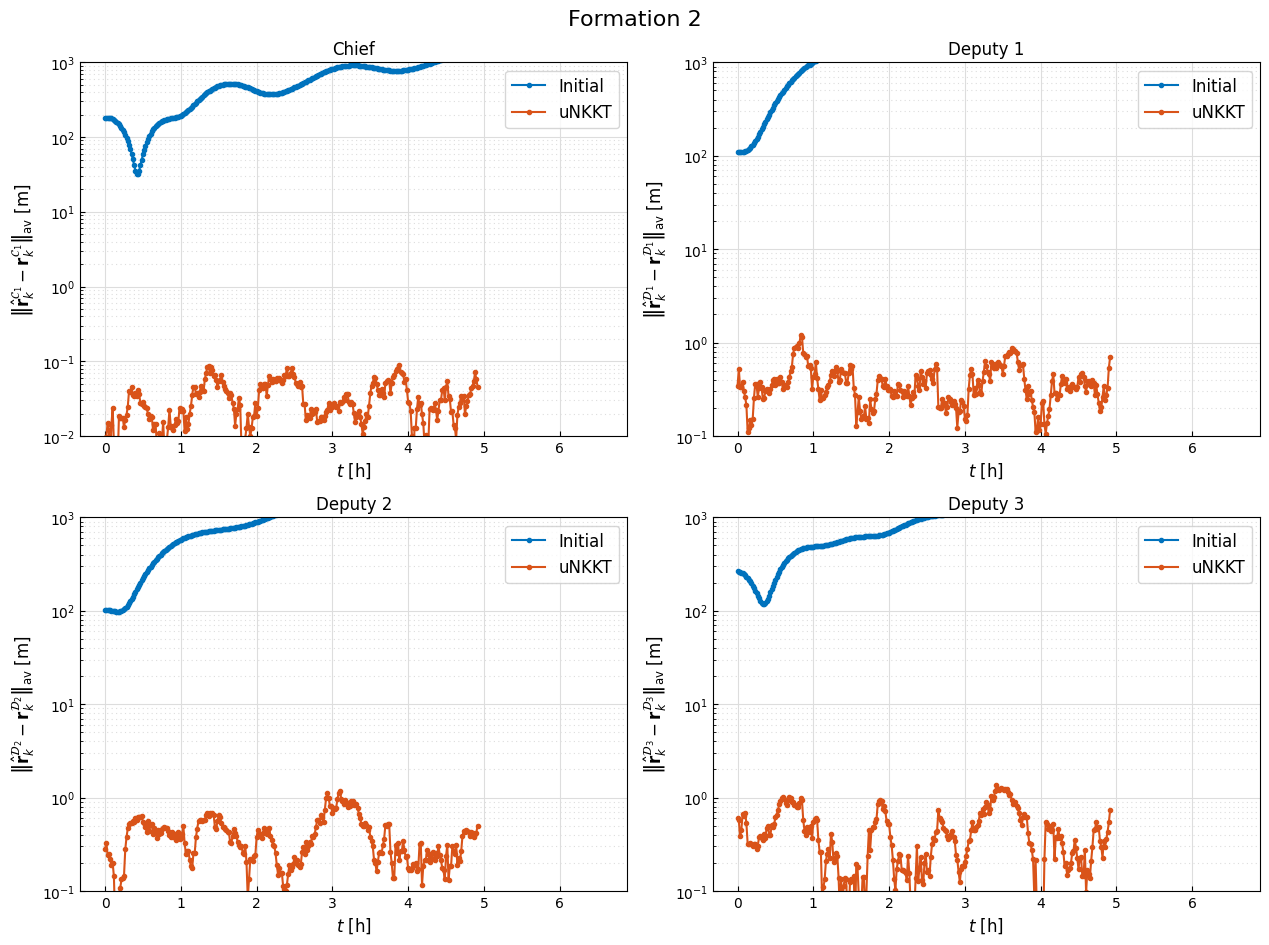

In [14]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt
algorithm = "uNKKT"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", label="Initial")
axs[0, 0].plot(time[:K - W + 1], dev_chief, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", label="Initial")
axs[0, 1].plot(time[:K - W + 1], dev_deputy1, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", label="Initial")
axs[1, 0].plot(time[:K - W + 1], dev_deputy2, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", label="Initial")
axs[1, 1].plot(time[:K - W + 1], dev_deputy3, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()